In [1]:
import numpy as np
import cupy as cp
import sys
import pandas as pd
import time

from holotomocupy.utils import *

astropy module not found
olefile module not found


In [2]:
# prb_opt = sys.argv[1]=='True'
# pos_opt = sys.argv[2]=='True'
# noise = sys.argv[3]=='True'
# method = sys.argv[4]
# niter = int(sys.argv[5])
# gpu = int(sys.argv[6])

prb_opt = True
pos_opt = True
noise = False
method = 'BH-CG'
niter = 4096
gpu = 0
cp.cuda.Device(gpu).use()

cpag = 5e-3
show = True

n = 1024  # object size in each dimension
pad = 0 # pad for the reconstructed probe
npos = 16 # total number of positions
z1 = 4.267e-3 # [m] position of the sample
detector_pixelsize = 3.0e-6
energy = 33.35  # [keV] xray energy
wavelength = 1.24e-09/energy  # [m] wave length
focusToDetectorDistance = 1.28  # [m]
z2 = focusToDetectorDistance-z1
distance = (z1*z2)/focusToDetectorDistance
magnification = focusToDetectorDistance/z1
voxelsize = np.abs(detector_pixelsize/magnification)  # object voxel size

extra = 8
nobj = n+n//8
nprb = n+2*pad
npatch = nprb+2*extra

path = f'/data/vnikitin/paper/near_field'
path_out = f'/data/vnikitin/paper/near_field/rec0'

In [3]:
os = 2
def mpad(psi):
    if os==2:
        psi = cp.pad(psi,((0,0),(npatch//2,npatch//2),(npatch//2,npatch//2)))
    return psi

def mcrop(psi):
    if os==2:
        res = psi[:,npatch//2:-npatch//2,npatch//2:-npatch//2]
    else:
        res = psi
    return res

def Lop(psi):
    fx = cp.fft.fftfreq(nprb, d=voxelsize).astype('float32')
    [fx, fy] = cp.meshgrid(fx, fx)
    fP = cp.exp(-1j*cp.pi*wavelength*distance*(fx**2+fy**2))
    ff = cp.fft.ifft2(cp.fft.fft2(psi)*fP)
    ff = ff[:,pad:nprb-pad,pad:nprb-pad]
    return ff

def LTop(psi):
    fx = cp.fft.fftfreq(nprb, d=voxelsize).astype('float32')
    [fx, fy] = cp.meshgrid(fx, fx)
    fP = cp.exp(1j*cp.pi*wavelength*distance*(fx**2+fy**2))
    ff = cp.pad(psi,((0,0),(pad,pad),(pad,pad)))    
    ff = cp.fft.ifft2(cp.fft.fft2(ff)*fP)
    return ff

def Ex(psi,ix):
    res = cp.empty([ix.shape[0],npatch,npatch],dtype='complex64')
    stx = nobj//2-ix[:,1]-npatch//2
    endx = stx+npatch
    sty = nobj//2-ix[:,0]-npatch//2
    endy = sty+npatch
    for k in range(len(stx)):
        res[k] = psi[sty[k]:endy[k],stx[k]:endx[k]]     
    return res

def ExT(psi,psir,ix):
    stx = nobj//2-ix[:,1]-npatch//2
    endx = stx+npatch
    sty = nobj//2-ix[:,0]-npatch//2
    endy = sty+npatch
    for k in range(len(stx)):
        psi[sty[k]:endy[k],stx[k]:endx[k]] += psir[k]
    return psi

def S(psi,p):    
    x = cp.fft.fftfreq(os*npatch).astype('float32')
    [y, x] = cp.meshgrid(x, x)
    pp = cp.exp(-2*cp.pi*1j * (y*p[:, 1, None, None]+x*p[:, 0, None, None])).astype('complex64')
    res = mcrop(cp.fft.ifft2(pp*cp.fft.fft2(mpad(psi))))
    return res

def Sop(psi,ix,x,ex):
    data = cp.zeros([x.shape[1], nprb, nprb], dtype='complex64')
    psir = Ex(psi,ix)     
    psir = S(psir,x)
    data = psir[:, ex:npatch-ex, ex:npatch-ex]
    return data

def STop(d,ix,x,ex):
    psi = cp.zeros([nobj, nobj], dtype='complex64')
    dr = cp.pad(d, ((0, 0), (ex, ex), (ex, ex)))
    dr = S(dr,-x)        
    ExT(psi,dr,ix)
    return psi

# adjoint tests
shifts_test = 30*(cp.random.random([npos,2])-0.5).astype('float32')
ishifts = shifts_test.astype('int32')
fshifts = shifts_test-ishifts

arr1 = (cp.random.random([nobj,nobj])+1j*cp.random.random([nobj,nobj])).astype('complex64')
arr2 = Ex(arr1,ishifts)
arr3 = arr1*0
ExT(arr3,arr2,ishifts)
print(f'{cp.sum(arr1*cp.conj(arr3))}==\n{cp.sum(arr2*cp.conj(arr2))}')

arr1 = (cp.random.random([nobj,nobj])+1j*cp.random.random([nobj,nobj])).astype('complex64')
arr2 = Sop(arr1,ishifts,fshifts,extra)
arr3 = STop(arr2,ishifts,fshifts,extra)
print(f'{cp.sum(arr1*cp.conj(arr3))}==\n{cp.sum(arr2*cp.conj(arr2))}')

arr1 = (cp.random.random([npos,nprb,nprb])+1j*cp.random.random([npos,nprb,nprb])).astype('complex64')
arr2 = Lop(arr1)
arr3 = LTop(arr2)
print(f'{cp.sum(arr1*cp.conj(arr3))}==\n{cp.sum(arr2*cp.conj(arr2))}')

(11524693-0.0006015559192746878j)==
(11524691+0.00012714837794192135j)
(11183048-0.566588282585144j)==
(11183049+9.39409073907882e-06j)
(11186192-0.043084703385829926j)==
(11186193-3.1384319299831986e-05j)


# read data

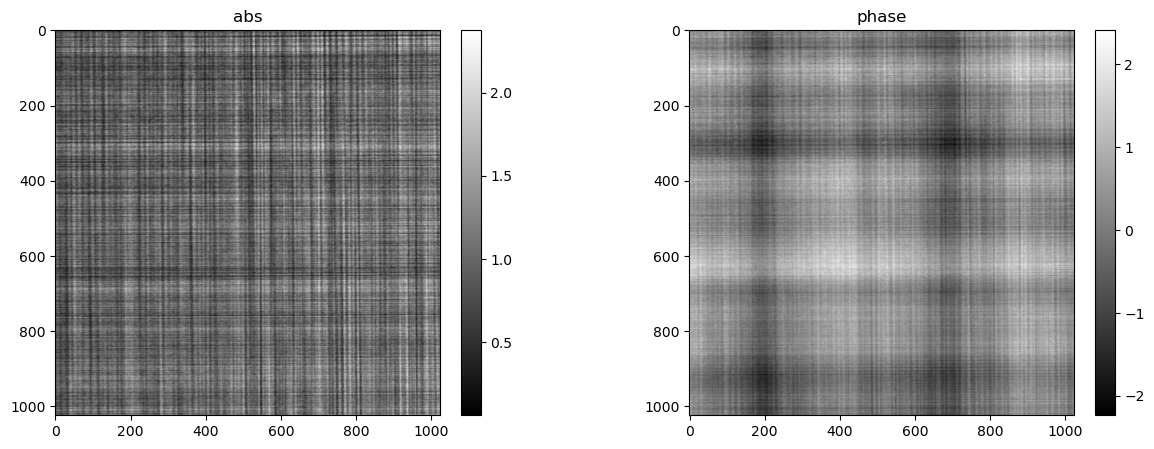

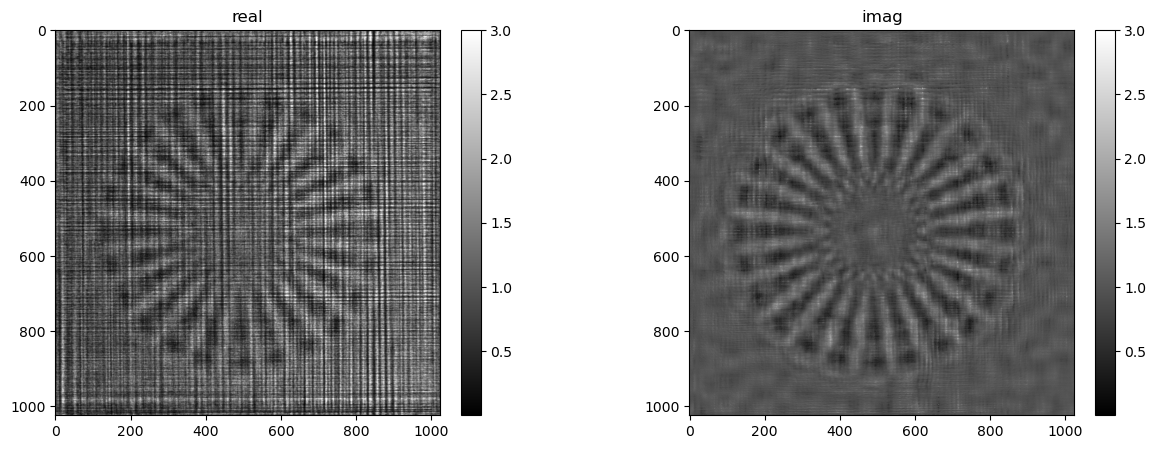

In [4]:
shifts = np.load(f'{path}/data/gen_shifts.npy')[:npos]
shifts_random = np.load(f'{path}/data/gen_shifts_random.npy')[:npos]
prb = np.load(f'{path}/data/gen_prb.npy')
if noise:
    data = np.load(f'{path}/data/ndata.npy')[:npos]
else:
    data = np.load(f'{path}/data/data.npy')[:npos]
ref = np.load(f'{path}/data/ref.npy')
psi = np.load(f'{path}/data/psi.npy')

mshow_polar(prb,show)
mshow_complex(data[0]+1j*data[0]/ref,show,vmax=3)

# Paganin reconstruction

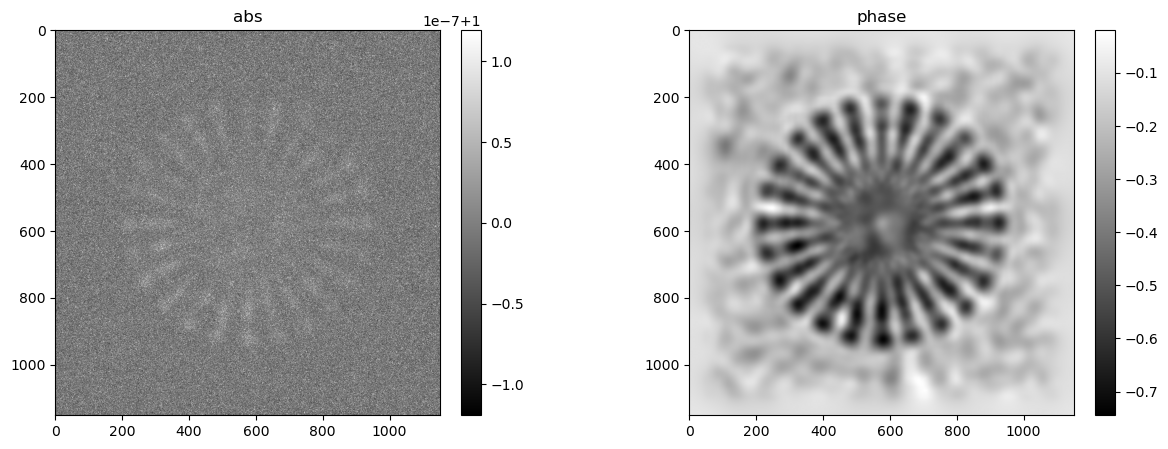

In [5]:
def Paganin(data, wavelength, voxelsize, delta_beta,  alpha):
    fx = cp.fft.fftfreq(data.shape[-1], d=voxelsize).astype('float32')
    [fx, fy] = cp.meshgrid(fx, fx)
    rad_freq = cp.fft.fft2(data)
    taylorExp = 1 + wavelength * distance * cp.pi * (delta_beta) * (fx**2+fy**2)
    numerator = taylorExp * (rad_freq)
    denominator = taylorExp**2 + alpha
    phase = cp.log(cp.real(cp.fft.ifft2(numerator / denominator)))
    phase = delta_beta * 0.5 * phase
    return phase

def rec_init(rdata,ishifts):
    recMultiPaganin = cp.zeros([nobj,nobj],dtype='float32')
    recMultiPaganinr = cp.zeros([nobj,nobj],dtype='float32')# to compensate for overlap
    for j in range(0,npos):
        r = rdata[j]        
        rr = r*0+1 # to compensate for overlap                
        rpsi = cp.ones([nobj,nobj],dtype='float32')
        rrpsi = cp.ones([nobj,nobj],dtype='float32')
        stx = nobj//2-ishifts[j,1]-n//2
        endx = stx+n
        sty = nobj//2-ishifts[j,0]-n//2
        endy = sty+n
        rpsi[sty:endy,stx:endx] = r
        rrpsi[sty:endy,stx:endx] = rr
        rpsi = Paganin(rpsi, wavelength, voxelsize,  24.05, cpag)
        recMultiPaganin += rpsi
        recMultiPaganinr += rrpsi
        
    recMultiPaganinr[np.abs(recMultiPaganinr)<5e-2] = 1    
    recMultiPaganin /= recMultiPaganinr    
    recMultiPaganin = np.exp(1j*recMultiPaganin)
    return recMultiPaganin

ishifts = cp.round(cp.array(shifts)).astype('int32')
rdata = cp.array(data/(ref+1e-5))
rec_paganin = rec_init(rdata,ishifts)
mshow_polar(rec_paganin,show)

##### $$\nabla F=2 \left(L^*\left( L\psi-\tilde d\right)\right).$$
##### where $$\tilde d = d \frac{L(\psi)}{|L(\psi)|}$$




In [6]:
def gradientF(vars, pars, reused, d):
    Lpsi =  reused['Lpsi']    
    if pars['model']=='Gaussian':
        td = d*(Lpsi/(np.abs(Lpsi)+pars['eps']))                
        res = 2*LTop(Lpsi - td)        
    elif pars['model']=='Poisson':
        dd = d*Lpsi/(cp.abs(Lpsi)**2+pars['eps']**2) 
        res = 2*LTop(Lpsi-dd)               
    return res

##### $$\nabla_{\psi} G|_{(q_0,\psi_0,\boldsymbol{x}_0)}= S_{\boldsymbol{x}_{0}}^*\left(\overline{J(q_0)}\cdot \nabla F\right)$$

##### $$\nabla_{q} G|_{(q_0,\psi_0,\boldsymbol{x}_0)}=J^*\left( \overline{S_{\boldsymbol{x}_{0}}(C_f^*(\psi_0)+\psi_{fr})}\cdot \nabla F\right).$$
##### $$\nabla_{\boldsymbol{x}_0} G|_{(q_0,\psi_0,\boldsymbol{x}_0)}=\textsf{Re}\Big(\big( \Big\langle \overline{q_0}\cdot \nabla F,   C(\mathcal{F}^{-1}(-2\pi i \xi_1 e^{ -2\pi i \boldsymbol{x}_{0,k}\cdot \boldsymbol{\xi}}\hat{\psi_0}))\Big\rangle,\Big\langle \overline{q_0}\cdot \nabla F,C(\mathcal{F}^{-1}(-2\pi i \xi_2 e^{ -2\pi i \boldsymbol{x}_{0,k}\cdot \boldsymbol{\xi}}\hat{\psi_0})) \Big\rangle\big)\Big)_{k=1}^K. $$




In [7]:
def gradient_psi(q,ix,x,ex,gradF):
    res =  STop(np.conj(q)*gradF,ix,x,ex)
    resp = Ex(res,ix)
    return res, resp

def gradient_prb(psi,ix,x,ex,gradF):
    return np.sum(np.conj(Sop(psi,ix,x,ex))*gradF,axis=0)

def gradient_shift(psi, q, ix, x, ex, gradF):    
    # frequencies
    xi1 = cp.fft.fftfreq(os*npatch).astype('float32')
    xi2, xi1 = cp.meshgrid(xi1, xi1)

    # multipliers in frequencies
    w = cp.exp(-2 * cp.pi * 1j * (xi1 * x[:, 0, None, None]+xi2 * x[:, 1, None, None]))
    w1 = xi1
    w2 = xi2
    
    # Gradient parts
    tmp = Ex(psi, ix)    
    tmp = cp.fft.fft2(mpad(tmp))
    dt1 = mcrop(cp.fft.ifft2(w*w1*tmp))
    dt2 = mcrop(cp.fft.ifft2(w*w2*tmp))
    dt1 = -2 * cp.pi * dt1[:,ex:nprb+ex,ex:nprb+ex]
    dt2 = -2 * cp.pi * dt2[:,ex:nprb+ex,ex:nprb+ex]
    
    # inner product with gradF
    gradx = cp.zeros([npos, 2], dtype='float32')
    gradx[:, 0] = imdot(gradF, q * dt1, axis=(1, 2))
    gradx[:, 1] = imdot(gradF, q * dt2, axis=(1, 2))

    return gradx

def gradients(vars,pars,reused):    
    (q,psi,x) = (vars['prb'], vars['psi'], vars['fshift'])
    (ix,ex,rho) = (pars['ishift'],pars['extra'],pars['rho'])
    gradF = reused['gradF']
    dpsi, dpsip = gradient_psi(q,ix,x,ex,gradF)
    dprb = gradient_prb(psi,ix,x,ex,gradF)
    dx = gradient_shift(psi,q,ix,x,ex,gradF)
    if sep:
        grads={'psi': dpsi,'psip': dpsip, 'prb': dprb, 'fshift': dx}
    else:
        grads={'psi': rho[0]*dpsi,'psip': rho[0]*dpsip, 'prb': rho[1]*dprb, 'fshift': rho[2]*dx}
    return grads

##### $$\frac{1}{2}\mathcal{H}|_{x_0}(y,z)= \left\langle \mathbf{1}-d_{0}, \mathsf{Re}({L(y)}\overline{L(z)})\right\rangle+\left\langle d_{0},(\mathsf{Re} (\overline{l_0}\cdot L(y)))\cdot (\mathsf{Re} (\overline{l_0}\cdot L(z))) \right\rangle$$
##### $$l_0=L(x_0)/|L(x_0)|$$
##### $$d_0=d/|L(x_0)|$$


In [8]:
def hessianF(Lm,Ldm1,Ldm2,data,pars):
    if pars['model']=='Gaussian':
        psi0p = Lm/(np.abs(Lm)+pars['eps'])
        d0 = data/(np.abs(Lm)+pars['eps'])
        v1 = np.sum((1-d0)*reprod(Ldm1,Ldm2))
        v2 = np.sum(d0*reprod(psi0p,Ldm1)*reprod(psi0p,Ldm2))                
    else:        
        psi0p = Lm/(cp.abs(Lm)+pars['eps'])            
        v1 = cp.sum((1-data/(cp.abs(Lm)**2+pars['eps']**2))*reprod(Ldm1,Ldm2))
        v2 = 2*cp.sum(data*reprod(psi0p,Ldm1)*reprod(psi0p,Ldm2)/(cp.abs(Lm)**2+pars['eps']**2))
    return 2*(v1+v2)

##### $D T_\psi|_{{{z}_0}}(\Delta {z})=-2\pi iC\Big(\mathcal{F}^{-1}\big({\Delta z \cdot \xi}) e^{-2\pi i  {z}_0\cdot {\xi}}\hat{\psi}({\xi})\big)\Big)=-2\pi i C\Big(\mathcal{F}^{-1}\big((\Delta z_1 {\xi_1}+\Delta z_2 {\xi_2}) e^{-2\pi i  {z}_0\cdot {\xi}}\hat{\psi}({\xi})\big)\Big)$
##### $ D^2{T_\psi}|_{{{z}_0}}(\Delta{z},\Delta{w})=-4\pi^2C(\mathcal{F}^{-1}((\Delta{z}\cdot\xi)(\Delta{w}\cdot\xi)e^{-2\pi i  {z}_0\cdot {\xi}}\hat{\psi}))$
##### $=-4\pi^2C(\mathcal{F}^{-1}((\Delta{z_1}\Delta{w_1}\xi_1^2 + (\Delta{z_1}\Delta{w_2}+\Delta{z_2}\Delta{w_1})\xi_1\xi_2+\Delta{z_2}\Delta{w_2}\xi_2^2)\hat{\psi}))$

#### $$ DM|_{(q_0,\psi_0,\boldsymbol{x})}(\Delta q, \Delta \psi,\Delta\boldsymbol{x})=$$
#### $$ \Big(\Delta q\cdot T_{\psi_0}({\boldsymbol{x}_{0,k}})+ q_0\cdot \big(T_{\Delta \psi}({\boldsymbol{x}_{0,k}})+  DT_{\psi_0}|_{{\boldsymbol{x}_{0,k}}}( \Delta \boldsymbol{x}_k)\big) \Big)_{k=1}^K=$$
#### $$ J(\Delta q)\cdot S_{\boldsymbol{x}_{0,k}}(\psi_0)+ J(q_0)\cdot S_{\boldsymbol{x}_{0}}{(\Delta \psi)}+  \Big(q_0\cdot DT_{\psi_0}|_{{\boldsymbol{x}_{0,k}}}( \Delta \boldsymbol{x}_k) \Big)_{k=1}^K$$


##### $$ D^2M|_{(q_0,\psi_0,\boldsymbol{x})}\big((\Delta q^{(1)}, \Delta \psi^{(1)},\Delta\boldsymbol{x}^{(1)}),(\Delta q^{(2)}, \Delta \psi^{(2)},\Delta\boldsymbol{x}^{(2)})\big)= $$
##### $$\Big( q_0\cdot DT_{\Delta\psi^{(1)}}|_{{\boldsymbol{x}_{0,k}}}( \Delta \boldsymbol{x}^{(2)})+q_0\cdot DT_{\Delta\psi^{(2)}}|_{{\boldsymbol{x}_{0,k}}}( \Delta \boldsymbol{x}^{(1)})+ q_0\cdot D^2{T_\psi}|_{{\boldsymbol{x}_0}}(\Delta\boldsymbol{x}^{(1)},\Delta\boldsymbol{x}^{(2)})+$$
##### $$\Delta q^{(1)}\cdot T_{\Delta \psi^{(2)}}({\boldsymbol{x}_{0,k}})+\Delta q^{(2)}\cdot T_{\Delta \psi^{(1)}}({\boldsymbol{x}_{0,k}})+ $$
##### $$\Delta q^{(1)}\cdot DT_{\psi_0}|_{{\boldsymbol{x}_{0,k}}}( \Delta \boldsymbol{x}^{(2)})+\Delta q^{(2)}\cdot DT_{\psi_0}|_{{\boldsymbol{x}_{0,k}}}( \Delta \boldsymbol{x}^{(1)})\Big)_{k=1}^K.$$


##### $$\mathcal{H}^G|_{ (q_0,\psi_0,\boldsymbol{x}_0)}\Big((\Delta q^{(1)},\Delta \psi^{(1)},\Delta \boldsymbol{x}^{(1)}),(\Delta q^{(2)},\Delta \psi^{(2)},\Delta \boldsymbol{x}^{(2)})\Big)=$$
##### $$\Big\langle \nabla F|_{M(q_0,\psi_0,\boldsymbol{x}_0)}, D^2M|_{(q_0,\psi_0,\boldsymbol{x}_0)}\Big((\Delta q^{(1)},\Delta \psi^{(1)},\Delta \boldsymbol{x}^{(1)}),(\Delta q^{(2)},\Delta \psi^{(2)},\Delta \boldsymbol{x}^{(2)})\Big)\Big\rangle +$$
##### $$\mathcal{H}^F|_{M(q_0,\psi_0,\boldsymbol{x}_0)}\Big(DM|_{(q_0,\psi_0,\boldsymbol{x}_0)}(\Delta q^{(1)},\Delta \psi^{(1)},\Delta \boldsymbol{x}^{(1)}),DM|_{(q_0,\psi_0,\boldsymbol{x}_0)}(\Delta q^{(2)},\Delta \psi^{(2)},\Delta \boldsymbol{x}^{(2)})\Big)$$


### Updates:

\begin{equation}
               \alpha_j=\frac{\mathsf{Re}\langle \nabla F|_{x_j},s_j\rangle}{H|_{x_j}( {s_j},s_j)}
             \end{equation}

\begin{equation}
                \beta_j=\frac{H(\nabla F|_{x_j},s_j)}{H|_{x_j}( {s_j},s_j)}.
\end{equation}

### Scaling variables:

\begin{equation}
\begin{aligned}
\tilde{\beta}_j=\frac{H^{\tilde{F}}|_{\tilde{x}_j} (\nabla \tilde{F}|_{\tilde{x}_j},\tilde{\eta}_j)}{H^{\tilde{F}}|_{\tilde{x}_j} (\tilde{\eta}_j,\tilde{\eta}_j)}=\frac{H^{F}|_{x_j} (\rho\nabla \tilde{F}|_{\tilde{x}_j},\rho\tilde{\eta}_j)}{H^{F}|_{x_j} (\rho\tilde{\eta}_j,\rho\tilde{\eta}_j)}=\frac{H^{F}|_{x_j} (\rho^2\nabla F|_{x_j},\rho\tilde{\eta}_j)}{H^{F}|_{x_j} (\rho\tilde{\eta}_j,\rho\tilde{\eta}_j)}
\end{aligned}
\end{equation}

\begin{equation}
\begin{aligned}
\tilde{\alpha}_j=\frac{\langle\nabla \tilde{F}|_{\tilde{x}_j},\tilde{\eta}_j\rangle}{H^{\tilde{F}}|_{\tilde{x}_j} (\tilde{\eta}_j,\tilde{\eta}_j)}=\frac{\langle \rho\nabla F|_{x_j},\tilde{\eta}_j\rangle}{H^{F}|_{x_j} (\rho\tilde{\eta}_j,\rho\tilde{\eta}_j)}
\end{aligned}
\end{equation}

\begin{equation}
    \begin{aligned}
        \tilde{\eta}_{j+1} = -\nabla \tilde{F}|_{\tilde{x}_j}+\tilde{\beta}_j\tilde{\eta}_j=-\rho\nabla F|_{x_j}+\tilde{\beta}_j\tilde{\eta}_j,\quad \text{with } \tilde{\eta}_0=-\rho\nabla F|_{x_0}
    \end{aligned}
\end{equation}

\begin{equation}
    \begin{aligned}
        \tilde{x}_{j+1} = \tilde{x}_{j}+\tilde{\alpha}_j\tilde{\eta}_{j+1}
    \end{aligned}
\end{equation}

Multiplying both sides by $\rho$,

\begin{equation}
    \begin{aligned}
        x_{j+1} = x_j+\rho\tilde{\alpha}_j\tilde{\eta}_{j+1}
    \end{aligned}
\end{equation}

# Optimized version, without extra functions

In [9]:
def calc_beta(vars,grads,etas,pars,reused,d):
    (q,psi,psip,x) = (vars['prb'], vars['psi'], vars['psip'], vars['fshift'])    
    (ix,ex,rho) = (pars['ishift'],pars['extra'],pars['rho'])
    (spsi,Lpsi,gradF) = (reused['spsi'], reused['Lpsi'], reused['gradF'])
    
    # note scaling with rho
    (dpsi1,dpsip1,dq1,dx1) = (grads['psi']*rho[0],grads['psip']*rho[0], grads['prb']*rho[1], grads['fshift']*rho[2])
    (dpsi2,dpsip2,dq2,dx2) = (etas['psi']*rho[0],etas['psip']*rho[0], etas['prb']*rho[1], etas['fshift']*rho[2])
        
    # frequencies
    xi1 = cp.fft.fftfreq(os*npatch).astype('float32')
    [xi2, xi1] = cp.meshgrid(xi1, xi1)    

    # multipliers in frequencies
    dx1 = dx1[:,:,np.newaxis,np.newaxis]
    dx2 = dx2[:,:,np.newaxis,np.newaxis]
    w = cp.exp(-2*cp.pi*1j * (xi2*x[:, 1, None, None]+xi1*x[:, 0, None, None]))
    w1 = xi1*dx1[:,0]+xi2*dx1[:,1]
    w2 = xi1*dx2[:,0]+xi2*dx2[:,1]
    w12 = xi1**2*dx1[:,0]*dx2[:,0]+ \
                xi1*xi2*(dx1[:,0]*dx2[:,1]+dx1[:,1]*dx2[:,0])+ \
                xi2**2*dx1[:,1]*dx2[:,1]
    w22 = xi1**2*dx2[:,0]**2+ 2*xi1*xi2*(dx2[:,0]*dx2[:,1]) + xi2**2*dx2[:,1]**2
    
    # DT, D2T terms
    # tmp1 = Ex(dpsi1,ix)     
    tmp1 = dpsip1#Ex(dpsi1,ix)     
    tmp1 = cp.fft.fft2(mpad(tmp1))
    sdpsi1 = mcrop(cp.fft.ifft2(w*tmp1))[:,ex:nprb+ex,ex:nprb+ex]
    dt12 = -2*np.pi*1j*mcrop(cp.fft.ifft2(w*w2*tmp1))[:,ex:nprb+ex,ex:nprb+ex]
    
    # tmp2 =Ex(dpsi2,ix)     
    tmp2 = dpsip2#Ex(dpsi2,ix)     
    tmp2 = cp.fft.fft2(mpad(tmp2))
    sdpsi2 = cp.fft.ifft2(w*tmp2)[:,ex:nprb+ex,ex:nprb+ex]
    dt21 = -2*np.pi*1j*mcrop(cp.fft.ifft2(w*w1*tmp2))[:,ex:nprb+ex,ex:nprb+ex]
    dt22 = -2*np.pi*1j*mcrop(cp.fft.ifft2(w*w2*tmp2))[:,ex:nprb+ex,ex:nprb+ex]
    
    # tmp = Ex(psi,ix)     
    tmp = psip#Ex(psi,ix)     
    tmp = cp.fft.fft2(mpad(tmp))
    dt1 = -2*np.pi*1j*mcrop(cp.fft.ifft2(w*w1*tmp))[:,ex:nprb+ex,ex:nprb+ex]
    dt2 = -2*np.pi*1j*mcrop(cp.fft.ifft2(w*w2*tmp))[:,ex:nprb+ex,ex:nprb+ex]
    d2t1 = -4*np.pi**2*mcrop(cp.fft.ifft2(w*w12*tmp))[:,ex:nprb+ex,ex:nprb+ex]
    d2t2 = -4*np.pi**2*mcrop(cp.fft.ifft2(w*w22*tmp))[:,ex:nprb+ex,ex:nprb+ex]
    
    # DM,D2M terms
    d2m1 =  q*dt12 + q*dt21 + q*d2t1
    d2m1 += dq1*sdpsi2 + dq2*sdpsi1
    d2m1 += dq1*dt2 + dq2*dt1

    d2m2 =  q*dt22 + q*dt22 + q*d2t2
    d2m2 += dq2*sdpsi2 + dq2*sdpsi2
    d2m2 += dq2*dt2 + dq2*dt2

    dm1 = dq1*spsi+q*(sdpsi1+dt1)   
    dm2 = dq2*spsi+q*(sdpsi2+dt2)   

    # top and bottom parts
    Ldm1 = Lop(dm1)
    Ldm2 = Lop(dm2) 
    top = redot(gradF,d2m1)+hessianF(Lpsi, Ldm1, Ldm2, d, pars)            
    bottom = redot(gradF,d2m2)+hessianF(Lpsi, Ldm2, Ldm2,d, pars)
    
    return top/bottom, top,bottom

def calc_alpha(vars,grads,etas,pars,reused,d):    
    (q,psi,psip,x) = (vars['prb'], vars['psi'], vars['psip'], vars['fshift'])    
    (ix,ex,rho) = (pars['ishift'],pars['extra'],pars['rho'])
    (dpsi1,dq1,dx1) = (grads['psi'], grads['prb'], grads['fshift'])
    (dpsi2,dq2,dx2) = (etas['psi'], etas['prb'], etas['fshift'])    
    (spsi,Lpsi,gradF) = (reused['spsi'],reused['Lpsi'], reused['gradF'])

    # top part
    top = -redot(dpsi1,dpsi2)-redot(dq1,dq2)-redot(dx1,dx2)
    
    # scale variable for the hessian
    (dpsi,dpsip,dq,dx) = (etas['psi']*rho[0],etas['psip']*rho[0], etas['prb']*rho[1], etas['fshift']*rho[2])

    # frequencies        
    xi1 = cp.fft.fftfreq(os*npatch).astype('float32')    
    [xi2, xi1] = cp.meshgrid(xi1, xi1)

    # multipliers in frequencies
    dx = dx[:,:,np.newaxis,np.newaxis]
    w = cp.exp(-2*cp.pi*1j * (xi2*x[:, 1, None, None]+xi1*x[:, 0, None, None]))
    w1 = xi1*dx[:,0]+xi2*dx[:,1]
    w2 = xi1**2*dx[:,0]**2+ 2*xi1*xi2*(dx[:,0]*dx[:,1]) + xi2**2*dx[:,1]**2
    
    # DT,D2T terms, and Spsi
    # tmp = Ex(dpsi,ix)     
    tmp = dpsip#Ex(dpsi,ix)     
    tmp = cp.fft.fft2(mpad(tmp))
    sdpsi = mcrop(cp.fft.ifft2(w*tmp))[:,ex:nprb+ex,ex:nprb+ex]
    dt2 = -2*np.pi*1j*mcrop(cp.fft.ifft2(w*w1*tmp))[:,ex:nprb+ex,ex:nprb+ex]
    
    # tmp = Ex(psi,ix)     
    tmp = psip#Ex(psi,ix)     
    tmp = cp.fft.fft2(mpad(tmp))
    dt = -2*np.pi*1j*mcrop(cp.fft.ifft2(w*w1*tmp))[:,ex:nprb+ex,ex:nprb+ex]
    d2t = -4*np.pi**2*mcrop(cp.fft.ifft2(w*w2*tmp))[:,ex:nprb+ex,ex:nprb+ex]
    
    # DM and D2M terms
    d2m2 = q*(2*dt2 + d2t)+2*dq*sdpsi+2*dq*dt
    dm = dq*spsi+q*(sdpsi+dt)   
            
    # bottom part
    Ldm = Lop(dm)
    bottom = redot(gradF,d2m2)+hessianF(Lpsi, Ldm, Ldm,d,pars)

    
    
    return top/bottom, top, bottom



def hessian(vars,grads,etas,pars,reused,d, rho1, rho2):    
    (q,psi,psip,x) = (vars['prb'], vars['psi'], vars['psip'], vars['fshift'])    
    (ix,ex,rho) = (pars['ishift'],pars['extra'],pars['rho'])
    (spsi,Lpsi,gradF) = (reused['spsi'], reused['Lpsi'], reused['gradF'])
    
    # note scaling with rho
    (dpsi1,dpsip1,dq1,dx1) = (grads['psi']*rho1[0],grads['psip']*rho1[0], grads['prb']*rho1[1], grads['fshift']*rho1[2])
    (dpsi2,dpsip2,dq2,dx2) = (etas['psi']*rho2[0],etas['psip']*rho2[0], etas['prb']*rho2[1], etas['fshift']*rho2[2])
        
    # frequencies
    xi1 = cp.fft.fftfreq(os*npatch).astype('float32')
    [xi2, xi1] = cp.meshgrid(xi1, xi1)    

    # multipliers in frequencies
    dx1 = dx1[:,:,np.newaxis,np.newaxis]
    dx2 = dx2[:,:,np.newaxis,np.newaxis]
    w = cp.exp(-2*cp.pi*1j * (xi2*x[:, 1, None, None]+xi1*x[:, 0, None, None]))
    w1 = xi1*dx1[:,0]+xi2*dx1[:,1]
    w2 = xi1*dx2[:,0]+xi2*dx2[:,1]
    w12 = xi1**2*dx1[:,0]*dx2[:,0]+ \
                xi1*xi2*(dx1[:,0]*dx2[:,1]+dx1[:,1]*dx2[:,0])+ \
                xi2**2*dx1[:,1]*dx2[:,1]
    w22 = xi1**2*dx2[:,0]**2+ 2*xi1*xi2*(dx2[:,0]*dx2[:,1]) + xi2**2*dx2[:,1]**2
    
    # DT, D2T terms
    tmp1 = Ex(dpsi1,ix)     
    # tmp1 = dpsip1#Ex(dpsi1,ix)     
    tmp1 = cp.fft.fft2(mpad(tmp1))
    sdpsi1 = mcrop(cp.fft.ifft2(w*tmp1))[:,ex:nprb+ex,ex:nprb+ex]
    dt12 = -2*np.pi*1j*mcrop(cp.fft.ifft2(w*w2*tmp1))[:,ex:nprb+ex,ex:nprb+ex]
    
    tmp2 =Ex(dpsi2,ix)     
    # tmp2 = dpsip2#Ex(dpsi2,ix)     
    tmp2 = cp.fft.fft2(mpad(tmp2))
    sdpsi2 = mcrop(cp.fft.ifft2(w*tmp2))[:,ex:nprb+ex,ex:nprb+ex]
    dt21 = -2*np.pi*1j*mcrop(cp.fft.ifft2(w*w1*tmp2))[:,ex:nprb+ex,ex:nprb+ex]
    dt22 = -2*np.pi*1j*mcrop(cp.fft.ifft2(w*w2*tmp2))[:,ex:nprb+ex,ex:nprb+ex]
    
    tmp = Ex(psi,ix)     
    # tmp = psip#Ex(psi,ix)     
    tmp = cp.fft.fft2(mpad(tmp)        )
    dt1 = -2*np.pi*1j*mcrop(cp.fft.ifft2(w*w1*tmp))[:,ex:nprb+ex,ex:nprb+ex]
    dt2 = -2*np.pi*1j*mcrop(cp.fft.ifft2(w*w2*tmp))[:,ex:nprb+ex,ex:nprb+ex]
    d2t1 = -4*np.pi**2*mcrop(cp.fft.ifft2(w*w12*tmp))[:,ex:nprb+ex,ex:nprb+ex]
    d2t2 = -4*np.pi**2*mcrop(cp.fft.ifft2(w*w22*tmp))[:,ex:nprb+ex,ex:nprb+ex]
    
    # DM,D2M terms
    d2m1 =  q*dt12 + q*dt21 + q*d2t1
    d2m1 += dq1*sdpsi2 + dq2*sdpsi1
    d2m1 += dq1*dt2 + dq2*dt1

    d2m2 =  q*dt22 + q*dt22 + q*d2t2
    d2m2 += dq2*sdpsi2 + dq2*sdpsi2
    d2m2 += dq2*dt2 + dq2*dt2

    dm1 = dq1*spsi+q*(sdpsi1+dt1)   
    dm2 = dq2*spsi+q*(sdpsi2+dt2)   

    # top and bottom parts
    Ldm1 = Lop(dm1)
    Ldm2 = Lop(dm2) 
    top = redot(gradF,d2m1)+hessianF(Lpsi, Ldm1, Ldm2, d, pars)            
    return top    

def calc_alpha_new(vars,grads,etas,pars,reused,d):
    (dpsi1,dq1,dx1) = (grads['psi'], grads['prb'], grads['fshift'])
    (dpsi2,dq2,dx2) = (etas['psi'], etas['prb'], etas['fshift'])    
    
    b = cp.array([-redot(dpsi1,dpsi2),-redot(dq1,dq2),-redot(dx1,dx2)],dtype='float32')
    
    A = cp.zeros([3,3],dtype='float32')
    for k1 in range(3):
        for k2 in range(3):
            rho1 = [0,0,0]
            rho2 = [0,0,0]
            rho1[k1] = 1
            rho2[k2] = 1
            A[k1,k2] = hessian(vars,etas,etas,pars,reused,d, rho1, rho2)    
    
    # if pars['rho'][1]==0:        
    #     A = A[:1,:1]
    #     b = b[:1]        
    #     alpha = cp.linalg.solve(A, b)
    #     top = alpha*b
    #     alpha = cp.append(alpha,[0,0])
    # elif pars['rho'][2]==0:        
    #     A = A[:2,:2]
    #     b = b[:2]
    #     alpha = cp.linalg.solve(A, b)        
    #     top = alpha[0]*b[0]+alpha[1]*b[1]
    #     alpha = cp.append(alpha,[0])
    # else:
    #     alpha = cp.linalg.solve(A, b)
    #     top = np.sum(alpha*b)
    


    ######TMP
    A = A[2:3,2:3]
    b = b[2:3]
    alpha = cp.linalg.solve(A, b)
    top = alpha*b
    alpha = cp.append([0,0],alpha)


    bottom = hessian(vars,etas,etas,pars,reused,d,alpha,alpha)
    # c1 = 0
    # for k1 in range(3):
    #     for k2 in range(3):
    #         rho1 = [0,0,0]
    #         rho2 = [0,0,0]
    #         rho1[k1] = alpha[k1]
    #         rho2[k2] = alpha[k2]
    #         c1 += hessian(vars,etas,etas,pars,reused,d, rho1, rho2)    
    # c2 = cp.matmul(alpha,cp.matmul(A,alpha))
    # print(f'{c=}, {c1=}, {c2=}')    

    return alpha, top, bottom# cp.array(np.linalg.eig(A.get()).eigenvectors[:,0]), np.linalg.eig(A.get()).eigenvalues[0]


## minimization functional and calculation of reused arrays

In [10]:
def minf(Lpsi,d,pars):
    if pars['model']=='Gaussian':
        f = cp.linalg.norm(cp.abs(Lpsi)-d)**2/(n*n*npos)    
    else:        
        f = cp.sum(cp.abs(Lpsi)**2-2*d*cp.log(cp.abs(Lpsi)+pars['eps']))/(n*n*npos)          
        # loss = torch.nn.PoissonNLLLoss(log_input=False, full=True, size_average=None, eps=pars['eps'], reduce=None, reduction='sum')
        # f = loss(torch.as_tensor(cp.abs(Lpsi)**2,device='cuda'),torch.as_tensor(d,device='cuda'))    
    return f

def calc_reused(vars, pars):
    
    (q,psi,psip,x) = (vars['prb'], vars['psi'],vars['psip'], vars['fshift'])    
    (ix,ex,rho) = (pars['ishift'],pars['extra'],pars['rho'])
    
    reused = {}
    reused['spsi'] = S(psip,x)[:, ex:npatch-ex, ex:npatch-ex]    
    reused['Lpsi'] = Lop(reused['spsi']*q)     
    return reused

## debug functions

In [11]:
def plot_debug(vars,etas,pars,top,bottom,alpha,data,i):
    '''Check the minimization functional behaviour'''
    if i % pars['vis_step'] == 0 and pars['vis_step'] != -1 and show:
        (q,psi,psip,x) = (vars['prb'], vars['psi'], vars['psip'], vars['fshift'])    
        (ix,ex,rho) = (pars['ishift'],pars['extra'],pars['rho'])
        (dpsi2,dpsip2,dq2,dx2) = (etas['psi'],etas['psip'], etas['prb'], etas['fshift'])    

        npp = 9
        errt = cp.zeros(npp*2)
        errt2 = cp.zeros(npp*2)
        for k in range(0,npp*2):
            psipt = psip+(alpha*k/(npp-1))*rho[0]*dpsip2
            psit = psi+(alpha*k/(npp-1))*rho[0]*dpsi2
            qt = q+(alpha*k/(npp-1))*rho[1]*dq2
            xt = x+(alpha*k/(npp-1))*rho[2]*dx2
            # errt[k] = minf(Lop(S(psipt,xt)[:, ex:npatch-ex, ex:npatch-ex]*qt),data,pars)
            errt[k] = minf(Lop(Sop(psit,ix,xt,ex)*qt),data,pars)
                    
        t = alpha*(cp.arange(2*npp))/(npp-1)    
        errt2 = minf(Lop(Sop(psi,ix,x,ex)*q),data,pars)
        errt2 = errt2 -top*t/(n*n*npos)+0.5*bottom*t**2/(n*n*npos)    
        # print(errt)
        plt.plot(alpha.get()*cp.arange(2*npp).get()/(npp-1),errt.get(),'.')
        plt.plot(alpha.get()*cp.arange(2*npp).get()/(npp-1),errt2.get(),'.')
        plt.show()

def plot_debug2(vars,etas,pars,top,bottom,alpha,data,i):
    '''Check the minimization functional behaviour'''
    if i % pars['vis_step'] == 0 and pars['vis_step'] != -1 and show:
        (q,psi,psip,x) = (vars['prb'], vars['psi'], vars['psip'], vars['fshift'])    
        (ix,ex,rho) = (pars['ishift'],pars['extra'],pars['rho'])
        (dpsi2,dpsip2,dq2,dx2) = (etas['psi'],etas['psip'], etas['prb'], etas['fshift'])    

        npp = 17
        errt = cp.zeros(npp*2)
        errt2 = cp.zeros(npp*2)
        for k in range(0,npp*2):
            psipt = psip+(alpha[0]*k/(npp-1))*dpsip2
            psit = psi+(alpha[0]*k/(npp-1))*dpsi2
            qt = q+(alpha[1]*k/(npp-1))*dq2
            xt = x+(alpha[2]*k/(npp-1))*dx2
            # errt[k] = minf(Lop(S(psipt,xt)[:, ex:npatch-ex, ex:npatch-ex]*qt),data,pars)
            errt[k] = minf(Lop(Sop(psit,ix,xt,ex)*qt),data,pars)
                    
        t = (cp.arange(2*npp))/(npp-1)    
        errt2 = minf(Lop(Sop(psi,ix,x,ex)*q),data,pars)
        errt2 = errt2 -top*t/(n*n*npos)+0.5*bottom*t**2/(n*n*npos)    
        plt.plot(errt.get(),'.')
        plt.plot(errt2.get(),'.')
        plt.show()

def vis_debug(vars,pars,i):
    '''Visualization and data saving'''
    if i % pars['vis_step'] == 0 and pars['vis_step'] != -1:
        (q,psi,x) = (vars['prb'], vars['psi'], vars['fshift'])        
        mshow_polar(psi,show)
        mshow_polar(q,show)
        write_tiff(np.angle(psi),f'{path_out}_{flg}/crec_psi_angle/{i:03}')
        write_tiff(np.abs(psi),f'{path_out}_{flg}/crec_psi_abs/{i:03}')
        write_tiff(np.angle(q),f'{path_out}_{flg}/crec_prb_angle/{i:03}')
        write_tiff(np.abs(q),f'{path_out}_{flg}/crec_prb_abs/{i:03}')
        np.save(f'{path_out}_{flg}/crec_shift_{i:03}',x)

def error_debug(vars, pars, reused, data, i):
    '''Visualization and data saving'''
    if i % pars['err_step'] == 0 and pars['err_step'] != -1:
        err = minf(reused['Lpsi'],data,pars)
        print(f'{i}) {err=:1.5e}',flush=True)                        
        vars['table'].loc[len(vars['table'])] = [i, err.get(), time.time()]
        vars['table'].to_csv(f'{flg}', index=False)            

def grad_debug(alpha, grads, pars, i):
    if i % pars['grad_step'] == 0 and pars['grad_step'] != -1:
        print(f'(alpha,psi,prb,shift): {alpha:.1e} {np.linalg.norm(grads['psi']):.1e},{np.linalg.norm(grads['prb']):.1e},{np.linalg.norm(grads['fshift']):.1e}')


In [12]:
def line_search(vars,pars,etas,d,reused,alpha):
    (q,psi,x) = (vars['prb'], vars['psi'], vars['fshift'])    
    (ix,ex,rho) = (pars['ishift'],pars['extra'],pars['rho'])
    (dpsi,dq,dx) = (etas['psi'], etas['prb'], etas['fshift'])    
    Lpsi = reused['Lpsi']
    err_best = minf(Lpsi,d,pars)
    
    step = 1
    for j in range(1):
        lflg=False
        rflg=False
        for k in range(100):
            psit = psi+alpha*rho[0]*dpsi
            qt = q+alpha*rho[1]*dq
            xt = x+alpha*rho[2]*dx
            errt = minf(Lop(Sop(psit,ix,xt,ex)*qt),d,pars)
            if err_best<errt:
                alpha/=(1+step)
                if rflg:
                    break            
                lflg=True
            elif err_best>errt:
                if lflg:
                    break            
                alpha*=(1+step)
                rflg=True        
            print(k)
        step/=2
    
    # print(alpha)
    return alpha


# Bilinear Hessian method

0) err=1.58744e-04


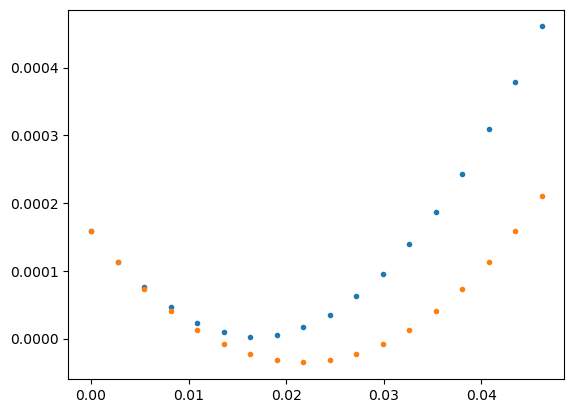

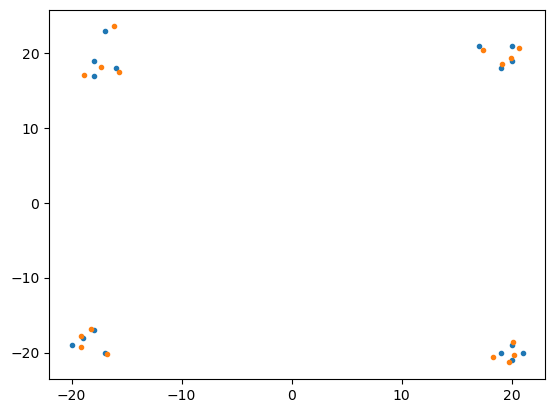

Timer unit: 1e-09 s

Total time: 0 s
File: /tmp/ipykernel_116701/3232175268.py
Function: calc_beta at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def calc_beta(vars,grads,etas,pars,reused,d):
     2                                               (q,psi,psip,x) = (vars['prb'], vars['psi'], vars['psip'], vars['fshift'])    
     3                                               (ix,ex,rho) = (pars['ishift'],pars['extra'],pars['rho'])
     4                                               (spsi,Lpsi,gradF) = (reused['spsi'], reused['Lpsi'], reused['gradF'])
     5                                               
     6                                               # note scaling with rho
     7                                               (dpsi1,dpsip1,dq1,dx1) = (grads['psi']*rho[0],grads['psip']*rho[0], grads['prb']*rho[1], grads['fshift']*rho[2])
     8                                               (dpsi2,dpsip2,dq2,

In [ ]:
import copy

def BH(data, vars, pars):
   
    if pars['model']=='Gaussian':
        # work with sqrt
        data = cp.sqrt(data)
    alpha=1    
    for i in range(pars['niter']):                             
        # if i<32:
        #     rho[2]=0
        # else:
        #     rho[2]=1
        reused = calc_reused(vars, pars)
        error_debug(vars, pars, reused, data, i)
        # vis_debug(vars, pars, i)            
      
        reused['gradF'] = gradientF(vars,pars,reused,data) 
        grads = gradients(vars,pars,reused)
        print(cp.linalg.norm(reused['gradF']))
        ss
        
        if i==0 or pars['method']=='BH-GD':
            etas = {}
            etas['psi'] = -grads['psi']
            etas['psip'] = -grads['psip']
            etas['prb'] = -grads['prb']
            etas['fshift'] = -grads['fshift']
            grads0 = copy.deepcopy(grads)
        else:      
            if pars['method']=='DY-LS':
                top =  cp.linalg.norm(grads['psi'] )**2 +  cp.linalg.norm(grads['prb'] )**2 + cp.linalg.norm(grads['fshift'] )**2 
                bottom = cp.real(cp.sum(cp.conj(etas['psi'])*(grads['psi']-grads0['psi'])))+\
                    cp.real(cp.sum(cp.conj(etas['prb'])*(grads['prb']-grads0['prb'])))+\
                    cp.real(cp.sum(cp.conj(etas['fshift'])*(grads['fshift']-grads0['fshift'])))           
                beta = top/bottom
                grads0 = copy.deepcopy(grads)
            else:
                beta,_,_ = calc_beta(vars, grads, etas, pars, reused, data)
                
            etas['psi'] = -grads['psi'] + beta*etas['psi']
            etas['psip'] = -grads['psip'] + beta*etas['psip']
            etas['prb'] = -grads['prb'] + beta*etas['prb']
            etas['fshift'] = -grads['fshift'] + beta*etas['fshift']

        
        if pars['method']=='DY-LS':
            alpha = line_search(vars,pars,etas,data,reused,alpha)
        else:
            if sep:
                alpha_new,top_new,bottom_new = calc_alpha_new(vars, grads, etas, pars, reused, data)  
                plot_debug2(vars,etas,pars,top_new,bottom_new,alpha_new,data,i)
                # grad_debug(alpha,grads,pars,i)                
            else:        
                alpha,top,bottom = calc_alpha(vars, grads, etas, pars, reused, data)                     
                plot_debug(vars,etas,pars,top,bottom,alpha,data,i)                
                # print('joint',alpha,'sep',*alpha_new)
        
        if sep:
            vars['psi'] += pars['rho'][0]*alpha_new[0]*etas['psi']
            vars['psip'] += pars['rho'][0]*alpha_new[0]*etas['psip']

            vars['prb'] += pars['rho'][1]*alpha_new[1]*etas['prb']
            vars['fshift'] += pars['rho'][2]*alpha_new[1]*etas['fshift']
        else:
            vars['psi'] += pars['rho'][0]*alpha*etas['psi']
            vars['psip'] += pars['rho'][0]*alpha*etas['psip']

            vars['prb'] += pars['rho'][1]*alpha*etas['prb']
            vars['fshift'] += pars['rho'][2]*alpha*etas['fshift']
        
    return vars


prb_opt = False
pos_opt = True


rho = [0,0,1]
if prb_opt:
    probe = prb*0+1
else:
    probe = prb
    rho[1] = 0
if pos_opt:
    positions_px = cp.array(shifts_random)#+(cp.random.random(shifts.shape)-0.5)*10
else:
    positions_px = cp.array(shifts)
    rho[2] = 0

# fixed variables
pars = {'niter': 1, 'err_step': 1, 'vis_step': 1, 'grad_step': 1}
pars['rho'] = rho
pars['ishift'] = cp.round(positions_px).astype('int32')
pars['extra'] = extra
pars['eps'] = 1e-8
pars['model'] = 'Gaussian'


sep = False
pars['method'] = 'BH-CG'
flg = f't{pars['method']}_True_{prb_opt}_{pos_opt}_{noise}'
vars = {}
vars['psi'] = cp.array(psi)#rec_paganin.copy()#*0+1
vars['psip'] = Ex(vars['psi'],pars['ishift'])#rec_paganin.copy()
vars['prb'] = cp.array(probe)
vars['fshift'] = cp.array(positions_px-cp.round(positions_px).astype('int32')).astype('float32')
vars['table'] = pd.DataFrame(columns=["iter", "err", "time"])

data_rec = cp.array(data).copy()
%load_ext line_profiler
%lprun -f calc_beta vars = BH(data_rec, vars, pars)      

erra=vars['table']['err'].values
times=vars['table']['time'].values
times-=times[0]
# plt.plot(erra,label='sep')
# plt.yscale('log')
# plt.grid('on')

plt.plot(shifts[:,0],shifts[:,1],'.')
shifts_rec = pars['ishift'].get()+vars['fshift'].get()
plt.plot(shifts_rec[:,0],shifts_rec[:,1],'.')


# sep = False
# pars['method'] = 'BH-CG'
# flg = f't{pars['method']}_True_{prb_opt}_{pos_opt}_{noise}'
# vars = {}
# vars['psi'] = rec_paganin.copy()#*0+1
# vars['psip'] = Ex(vars['psi'],pars['ishift'])#rec_paganin.copy()
# vars['prb'] = cp.array(probe)
# vars['fshift'] = cp.array(positions_px-cp.round(positions_px).astype('int32')).astype('float32')
# vars['table'] = pd.DataFrame(columns=["iter", "err", "time"])

# data_rec = cp.array(data).copy()
# %load_ext line_profiler
# %lprun -f calc_beta vars = BH(data_rec, vars, pars)      

# erra2=vars['table']['err'].values
# times=vars['table']['time'].values
# times-=times[0]

# plt.plot(erra,label='sep')
# plt.plot(erra2,label='joint')
# plt.yscale('log')
# plt.grid('on')
# plt.legend()
